In [3]:
from sklearn.datasets import load_diabetes
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [4]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [5]:
# Standardize data (important for SGD)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
class CustomSGDRegressor:
    
    def __init__(self, learning_rate=0.01, epochs=100, batch_size=1):
        self.coef_ = None
        self.intercept_ = None
        self.lr = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_history = []
        
    def fit(self, X_train, y_train):
        # Initialize parameters
        self.intercept_ = 0
        self.coef_ = np.zeros(X_train.shape[1])
        
        for epoch in range(self.epochs):
            # Shuffle data each epoch
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            
            for i in range(0, X_train.shape[0], self.batch_size):
                batch_indices = indices[i:i+self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]
                
                # Calculate prediction and error
                y_hat = np.dot(X_batch, self.coef_) + self.intercept_
                error = y_batch - y_hat
                
                # Update parameters
                self.intercept_ += self.lr * np.mean(error)
                self.coef_ += self.lr * np.dot(X_batch.T, error) / self.batch_size
            
            # Track loss
            y_hat_full = np.dot(X_train, self.coef_) + self.intercept_
            loss = np.mean((y_train - y_hat_full)**2)
            self.loss_history.append(loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")
    
    def predict(self, X_test):
        return np.dot(X_test, self.coef_) + self.intercept_

In [8]:
print("SGD Implementation:")
custom_sgd = CustomSGDRegressor(learning_rate=0.01, epochs=50, batch_size=32)
start_time = time.time()
custom_sgd.fit(X_train_scaled, y_train)
custom_time = time.time() - start_time

SGD Implementation:
Epoch 0: Loss = 22672.1799
Epoch 10: Loss = 4663.0443
Epoch 20: Loss = 3046.0508
Epoch 30: Loss = 2859.2605
Epoch 40: Loss = 2850.4434


In [9]:
y_pred_custom = custom_sgd.predict(X_test_scaled)
custom_r2 = r2_score(y_test, y_pred_custom)

In [10]:
# Scikit-learn's SGD
print("\nScikit-learn SGDRegressor:")
sklearn_sgd = SGDRegressor(max_iter=50, learning_rate='constant', 
                          eta0=0.01, random_state=2, tol=None)


Scikit-learn SGDRegressor:


In [11]:
start_time = time.time()
sklearn_sgd.fit(X_train_scaled, y_train)
sklearn_time = time.time() - start_time

In [12]:
y_pred_sklearn = sklearn_sgd.predict(X_test_scaled)
sklearn_r2 = r2_score(y_test, y_pred_sklearn)

In [13]:
# Results comparison
print("\nResults Comparison:")
print(f"{'Metric':<20} {'Custom SGD':<15} {'Sklearn SGD':<15}")
print(f"{'R2 Score':<20} {custom_r2:<15.4f} {sklearn_r2:<15.4f}")
print(f"{'Time (seconds)':<20} {custom_time:<15.4f} {sklearn_time:<15.4f}")
print(f"{'Intercept':<20} {custom_sgd.intercept_:<15.4f} {sklearn_sgd.intercept_[0]:<15.4f}")


Results Comparison:
Metric               Custom SGD      Sklearn SGD    
R2 Score             0.4443          0.4368         
Time (seconds)       0.0192          0.0192         
Intercept            148.2655        152.0455       


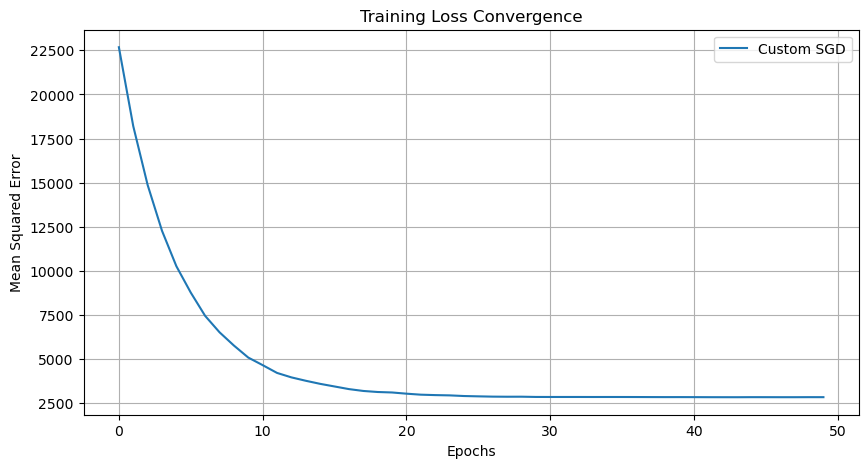

In [14]:
# Plot convergence
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(custom_sgd.loss_history, label='Custom SGD')
plt.title("Training Loss Convergence")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()